In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.svm import SVC
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from nltk.stem import PorterStemmer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
import umap


Getting familiar with the dataset

In [2]:
file_path = "Project1-ClassificationDataset.csv"
df = pd.read_csv(file_path)

rows, columns = df.shape
print("The dataset has {} rows and {} columns.".format(rows, columns))

The dataset has 3476 rows and 8 columns.


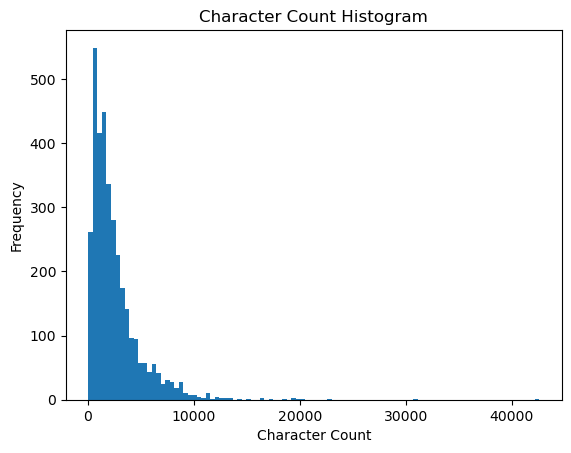

In [3]:
df['char_count'] = df['full_text'].apply(lambda x: sum(c.isalnum() for c in str(x)))

plt.hist(df['char_count'], bins=100)
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.title("Character Count Histogram")
plt.show()

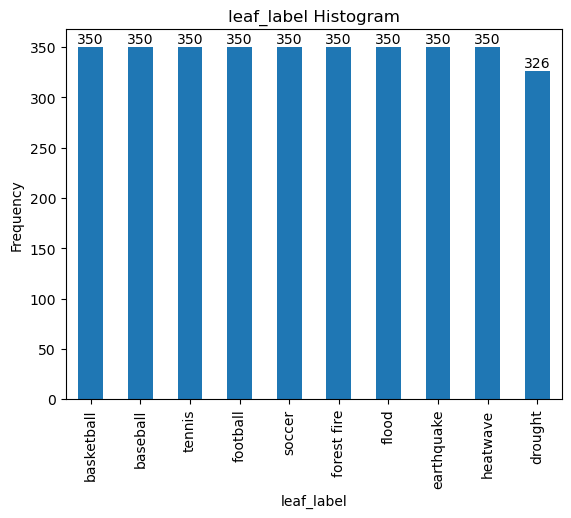

In [4]:
counts = df['leaf_label'].value_counts()
counts.plot(kind='bar')
for i, value in enumerate(counts):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')
plt.xlabel('leaf_label')
plt.ylabel('Frequency')
plt.title('leaf_label Histogram')
plt.show()

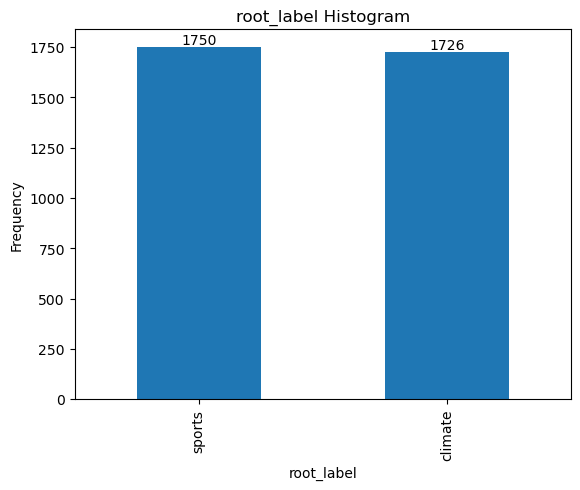

In [5]:
counts = df['root_label'].value_counts()
counts.plot(kind='bar')
for i, value in enumerate(counts):
    plt.text(i, value + 1, str(value), ha='center', va='bottom')
plt.xlabel('root_label')
plt.ylabel('Frequency')
plt.title('root_label Histogram')
plt.show()

Binary Classification

In [6]:
np.random.seed(42)
random.seed(42)

1. Splitting the entire dataset into training and testing data.

In [7]:
train, test = train_test_split(df[["full_text", "root_label"]], test_size=0.2)
print("The training set has {} rows and {} columns.".format(train.shape[0], train.shape[1]))
print("The test set has {} rows and {} columns.".format(test.shape[0], test.shape[1]))

The training set has 2780 rows and 2 columns.
The test set has 696 rows and 2 columns.


2. Feature extraction

In [7]:
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [9]:
train['cleaned_text'] = train['full_text'].apply(lambda x: clean(x))
test['cleaned_text'] = test['full_text'].apply(lambda x: clean(x))

In [8]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    #Since the some tokens contain punctuation, strip punctuation from each token
    tokens = [word.strip(string.punctuation) for word in tokens]
    tokens = [subtoken for token in tokens for subtoken in token.split('-')]
    # print(f"Tokens before POS tagging: {tokens}")  # Debug line
    
    pos_tags = pos_tag(tokens)
    # print(f"POS tags: {pos_tags}")  # Debug line

    lemmatized_tokens = [
        lemmatizer.lemmatize(word, pos='n') if 'NN' in tag else
        lemmatizer.lemmatize(word, pos='v') if 'VB' in tag else
        lemmatizer.lemmatize(word, pos='a') if 'JJ' in tag else
        lemmatizer.lemmatize(word, pos='r') if 'RB' in tag else
        word
        for word, tag in pos_tags
        if word.isalpha()
    ]

    # print(f"Lemmatized Tokens: {lemmatized_tokens}\n")  # Debug line

    return ' '.join(lemmatized_tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zedpro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/zedpro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/zedpro/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/zedpro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zedpro/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/zedpro/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /Users/zedpro/nltk_data...
[n

In [11]:
train['lemmatized_text'] = train['cleaned_text'].apply(lambda x: lemmatize_text(x))
test['lemmatized_text'] = test['cleaned_text'].apply(lambda x: lemmatize_text(x))

In [ ]:
vectorizer = CountVectorizer(stop_words='english', min_df=3)

train_vectors = vectorizer.fit_transform(train['lemmatized_text'])
test_vectors = vectorizer.transform(test['lemmatized_text'])

print("The training vecotrs has {} rows and {} columns.".format(train_vectors.shape[0], train_vectors.shape[1]))
print("The test vectors has {} rows and {} columns.".format(test_vectors.shape[0], test_vectors.shape[1]))


In [ ]:
transformer = TfidfTransformer()

train_tfidf = transformer.fit_transform(train_vectors)
test_tfidf = transformer.transform(test_vectors)

print("The training matrix has {} rows and {} columns.".format(train_tfidf.shape[0], train_tfidf.shape[1]))
print("The test matrix has {} rows and {} columns.".format(test_tfidf.shape[0], test_tfidf.shape[1]))


The training matrix has 2780 rows and 13874 columns.
The test matrix has 696 rows and 13874 columns.


3. Dimensionality Reduction

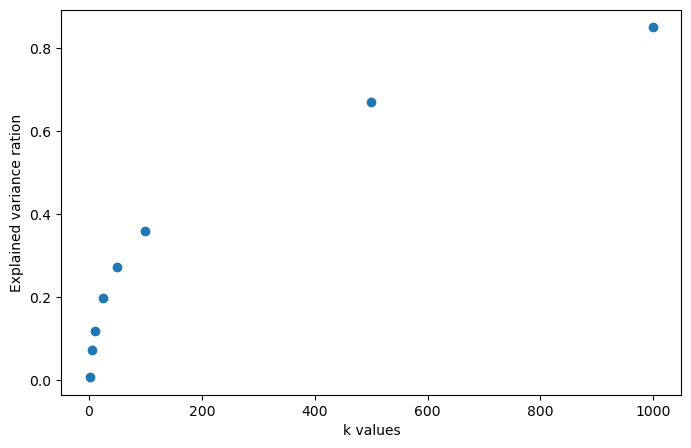

In [ ]:
k_values = [1, 5, 10, 25, 50, 100, 500, 1000]
explained_variance_ratio = []

for k in k_values:
    svd = TruncatedSVD(n_components=k, random_state=42)
    svd.fit(train_tfidf)
    explained_variance_ratio.append(svd.explained_variance_ratio_.sum())

plt.figure(figsize=(8, 5))
plt.plot(k_values, explained_variance_ratio, 'o')
plt.xlabel('k values')
plt.ylabel('Explained variance ration')
plt.show()

In [21]:
k = 25

svd = TruncatedSVD(n_components=k, random_state=42)
train_LSI = svd.fit_transform(train_tfidf)
test_LSI = svd.transform(test_tfidf)

train_LSI_reconstructed = svd.inverse_transform(train_LSI)

nmf = NMF(n_components=k, init='nndsvd', random_state=42)
train_NMF = nmf.fit_transform(train_tfidf)
test_NMF = nmf.transform(test_tfidf)

train_NMF_reconstructed = np.dot(train_NMF, nmf.components_)

mse_LSI = np.linalg.norm(train_tfidf - train_LSI_reconstructed, 'fro') ** 2
mse_NMF = np.linalg.norm(train_tfidf - train_NMF_reconstructed, 'fro') ** 2

print(f"LSI reconstruction residual MSE error: {mse_LSI: .4f}")
print(f"NMF reconstruction residual MSE error: {mse_NMF: .4f}")


LSI reconstruction residual MSE error:  2158.6332
NMF reconstruction residual MSE error:  2172.5907


4. Classification Algorithms

In [23]:
print('Shape of LSI training matrix:', train_LSI.shape)

def y_label(root_label):
    return 0 if 'sports' in root_label else 1

y_train = [y_label(label) for label in train['root_label']]
y_test = [y_label(label) for label in test['root_label']]
class_names = ['sports', 'climate']

Shape of LSI training matrix: (2780, 25)


SVM

In [9]:
def evaluate_model(title, y_true, y_hat):
    cm = confusion_matrix(y_true, y_hat)
    acc = accuracy_score(y_true, y_hat)
    rec = recall_score(y_true, y_hat)
    prec = precision_score(y_true, y_hat)
    f1 = f1_score(y_true, y_hat)

    print(title)
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"F1 Score: {f1:.4f}")

def plot_roc_curve(model, X_test, y_test, title):
    y_score = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'{title} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(len(classes)), classes, rotation=45, ha="right")
    plt.yticks(np.arange(len(classes)), classes)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Gemma = 2000

SVM hard margin
Confusion Matrix:
[[350  18]
 [ 20 308]]
Accuracy: 0.9454
Recall: 0.9390
Precision: 0.9448
F1 Score: 0.9419


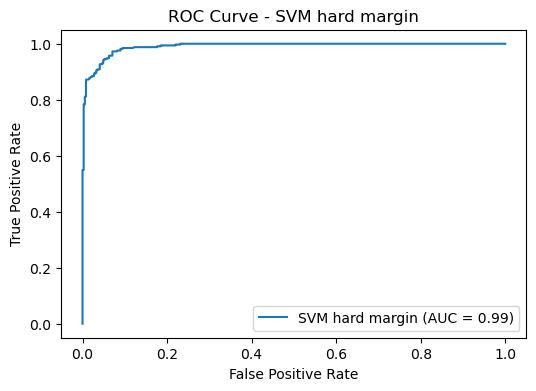

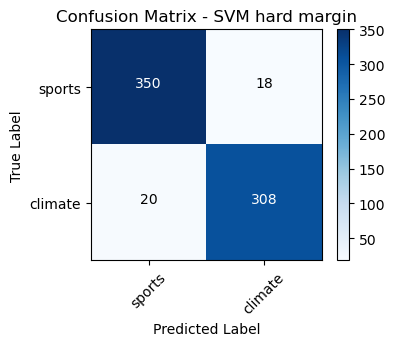

In [33]:
svm_hard = SVC(kernel='linear', C=2000, random_state=42)
svm_hard.fit(train_LSI, y_train)
    
hard_predictions = svm_hard.predict(test_LSI)
hard_cm = confusion_matrix(y_test, hard_predictions)

evaluate_model(f"SVM hard margin", y_test, hard_predictions)
plot_roc_curve(svm_hard, test_LSI, y_test, "SVM hard margin")
plot_confusion_matrix(hard_cm, classes=class_names, title=f'Confusion Matrix - SVM hard margin')

Gemma = 0.0005

SVM soft margin
Confusion Matrix:
[[  0 368]
 [  0 328]]
Accuracy: 0.4713
Recall: 1.0000
Precision: 0.4713
F1 Score: 0.6406


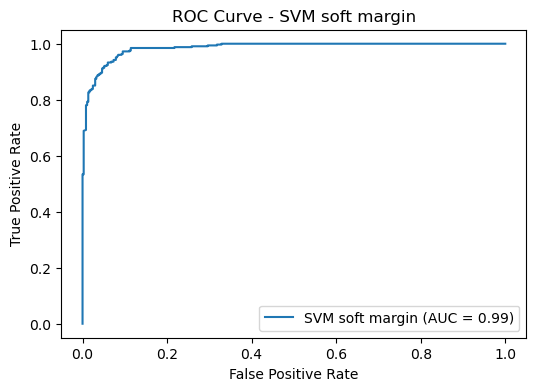

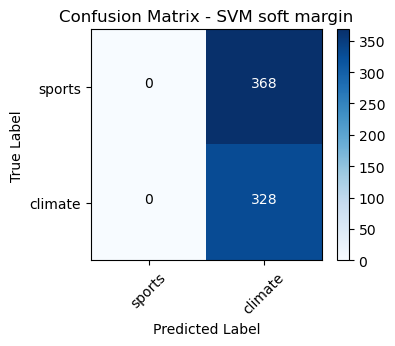

In [34]:
svm_soft = SVC(kernel='linear', C=0.0005, random_state=42)
svm_soft.fit(train_LSI, y_train)
    
soft_predictions = svm_soft.predict(test_LSI)
soft_cm = confusion_matrix(y_test, soft_predictions)

evaluate_model(f"SVM soft margin", y_test, soft_predictions)
plot_roc_curve(svm_soft, test_LSI, y_test, "SVM soft margin")
plot_confusion_matrix(soft_cm, classes=class_names, title=f'Confusion Matrix - SVM soft margin')

Gemma = 100000

SVM extreme hard margin
Confusion Matrix:
[[350  18]
 [ 20 308]]
Accuracy: 0.9454
Recall: 0.9390
Precision: 0.9448
F1 Score: 0.9419


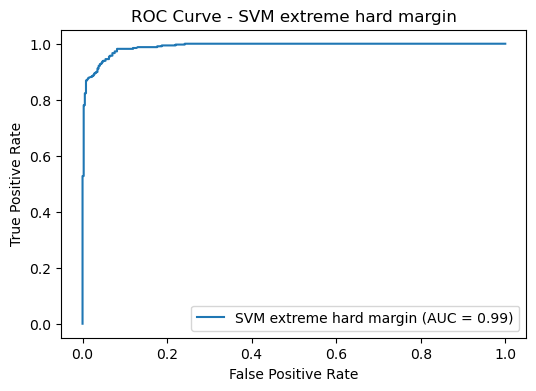

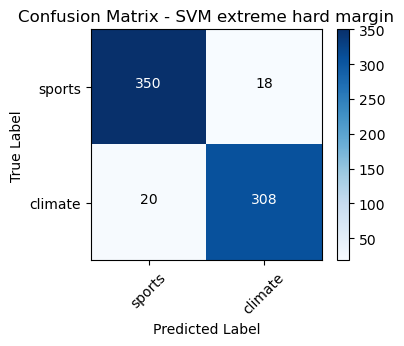

In [35]:
svm_extreme_hard = SVC(kernel='linear', C=100000, random_state=42)
svm_extreme_hard.fit(train_LSI, y_train)
    
xhard_predictions = svm_extreme_hard.predict(test_LSI)
xhard_cm = confusion_matrix(y_test, xhard_predictions)

evaluate_model(f"SVM extreme hard margin", y_test, xhard_predictions)
plot_roc_curve(svm_extreme_hard, test_LSI, y_test, "SVM extreme hard margin")
plot_confusion_matrix(xhard_cm, classes=class_names, title=f'Confusion Matrix - SVM extreme hard margin')

Cross-Validation

Gemma = 0.001, Mean Accuracy = 0.5029
Gemma = 0.01, Mean Accuracy = 0.7838
Gemma = 0.1, Mean Accuracy = 0.9284
Gemma = 1, Mean Accuracy = 0.9406
Gemma = 10, Mean Accuracy = 0.9500
Gemma = 100, Mean Accuracy = 0.9522
Gemma = 1000, Mean Accuracy = 0.9511
Gemma = 10000, Mean Accuracy = 0.9529
Gemma = 100000, Mean Accuracy = 0.9525
Gemma = 1000000, Mean Accuracy = 0.9525

Best gemma from Cross-Validation: 10000
Best SVM
Confusion Matrix:
[[350  18]
 [ 20 308]]
Accuracy: 0.9454
Recall: 0.9390
Precision: 0.9448
F1 Score: 0.9419


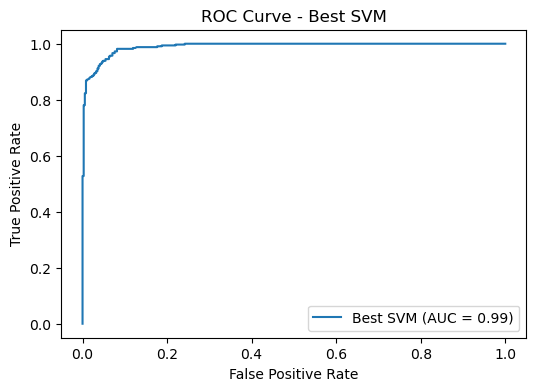

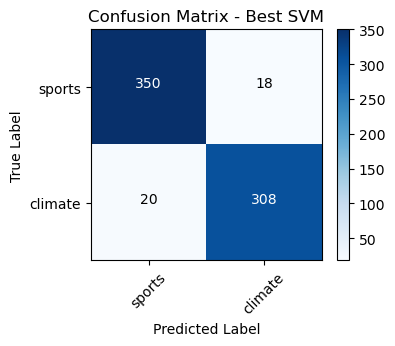

In [37]:
gamma_range = [10**i for i in range(-3, 7)]
validation_scores = []

for gamma in gamma_range:
    svm_cv = SVC(kernel='linear', C=gamma, random_state=42)
    scores = cross_val_score(svm_cv, train_LSI, y_train, cv=5)
    validation_scores.append(scores.mean())
    print(f"Gemma = {gamma}, Mean Accuracy = {scores.mean():.4f}")

best_gamma_index = np.argmax(validation_scores)
best_gamma = gamma_range[best_gamma_index]
print(f"\nBest gemma from Cross-Validation: {best_gamma}")

svm_best = SVC(kernel='linear', C=best_gamma, random_state=42)
svm_best.fit(train_LSI, y_train)
    
best_predictions = svm_best.predict(test_LSI)
best_cm = confusion_matrix(y_test, best_predictions)

evaluate_model(f"Best SVM", y_test, best_predictions)
plot_roc_curve(svm_best, test_LSI, y_test, "Best SVM")
plot_confusion_matrix(best_cm, classes=class_names, title=f'Confusion Matrix - Best SVM')


Logistic Regression

Without Regularization

Logistic Regression (No Regularization)
Confusion Matrix:
[[347  21]
 [ 19 309]]
Accuracy: 0.9425
Recall: 0.9421
Precision: 0.9364
F1 Score: 0.9392


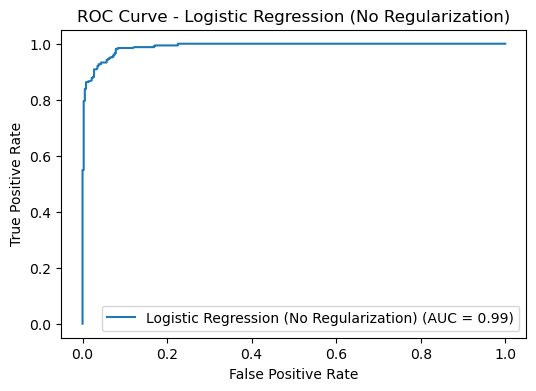

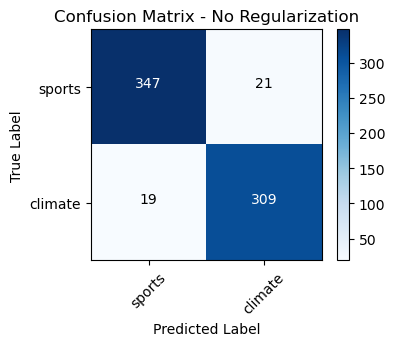

In [ ]:
log_reg_noreg = LogisticRegression(penalty=None, solver='newton-cholesky', random_state=42)
log_reg_noreg.fit(train_LSI, y_train)

predictions_noreg = log_reg_noreg.predict(test_LSI)
cm_noreg = confusion_matrix(y_test, predictions_noreg)

evaluate_model(f"Logistic Regression (No Regularization)", y_test, predictions_noreg)
plot_roc_curve(log_reg_noreg, test_LSI, y_test, "Logistic Regression (No Regularization)")
plot_confusion_matrix(cm_noreg, classes=class_names, title="Confusion Matrix - No Regularization")


In [40]:
strength_value = {'C': [10**k for k in range(-5, 6)]}

L1 Regularization

Best L1 regularization strength: 10, best score is 0.9504
Logistic Regression (L1 Regularization)
Confusion Matrix:
[[348  20]
 [ 22 306]]
Accuracy: 0.9397
Recall: 0.9329
Precision: 0.9387
F1 Score: 0.9358


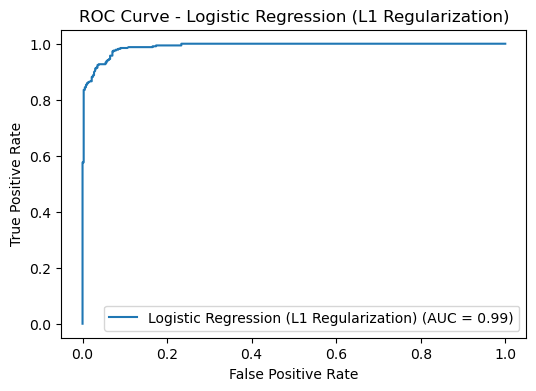

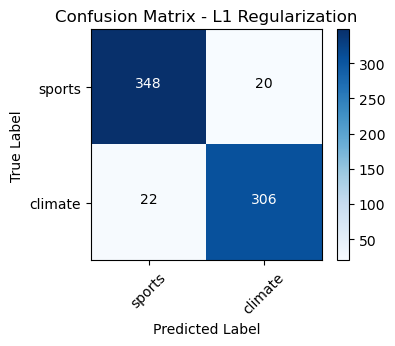

In [43]:
log_reg_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
grid_L1 = GridSearchCV(log_reg_l1, strength_value, cv=5, scoring='accuracy')
grid_L1.fit(train_LSI, y_train)
best_C_l1 = grid_L1.best_params_['C']
best_l1_score = grid_L1.best_score_
print(f"Best L1 regularization strength: {best_C_l1}, best score is {best_l1_score:.4f}")

log_reg_l1_best = LogisticRegression(penalty='l1', C=best_C_l1, solver='liblinear', random_state=42)
log_reg_l1_best.fit(train_LSI, y_train)

predictions_l1 = log_reg_l1_best.predict(test_LSI)
cm_l1 = confusion_matrix(y_test, predictions_l1)

evaluate_model(f"Logistic Regression (L1 Regularization)", y_test, predictions_l1)
plot_roc_curve(log_reg_l1_best, test_LSI, y_test, "Logistic Regression (L1 Regularization)")
plot_confusion_matrix(cm_l1, classes=class_names, title="Confusion Matrix - L1 Regularization")

L2 Regularization

Best L2 regularization strength: 100, best score is 0.9504
Logistic Regression (L2 Regularization)
Confusion Matrix:
[[349  19]
 [ 22 306]]
Accuracy: 0.9411
Recall: 0.9329
Precision: 0.9415
F1 Score: 0.9372


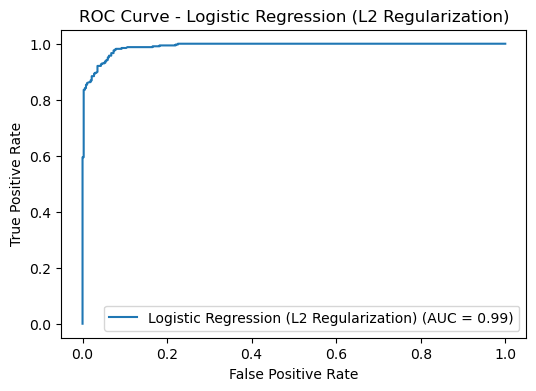

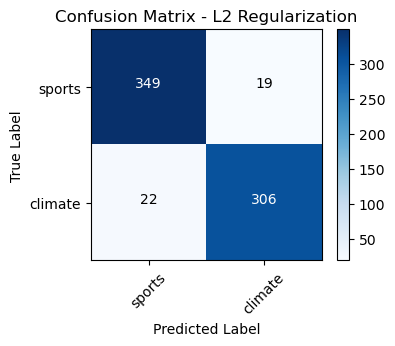

In [47]:
log_reg_l2 = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
grid_L2 = GridSearchCV(log_reg_l2, strength_value, cv=5, scoring='accuracy')
grid_L2.fit(train_LSI, y_train)
best_C_l2 = grid_L2.best_params_['C']
best_l2_score = grid_L2.best_score_
print(f"Best L2 regularization strength: {best_C_l2}, best score is {best_l2_score:.4f}")

log_reg_l2_best = LogisticRegression(penalty='l2', C=best_C_l2, solver='liblinear', random_state=42)
log_reg_l2_best.fit(train_LSI, y_train)

predictions_l2 = log_reg_l2_best.predict(test_LSI)
cm_l2 = confusion_matrix(y_test, predictions_l2)

evaluate_model(f"Logistic Regression (L2 Regularization)", y_test, predictions_l2)
plot_roc_curve(log_reg_l2_best, test_LSI, y_test, "Logistic Regression (L2 Regularization)")
plot_confusion_matrix(cm_l2, classes=class_names, title="Confusion Matrix - L2 Regularization")

Naive Bayes Model

Gaussian Naive Bayes
Confusion Matrix:
[[357  11]
 [ 53 275]]
Accuracy: 0.9080
Recall: 0.8384
Precision: 0.9615
F1 Score: 0.8958


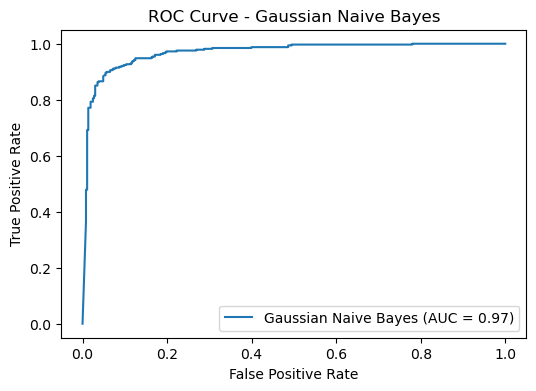

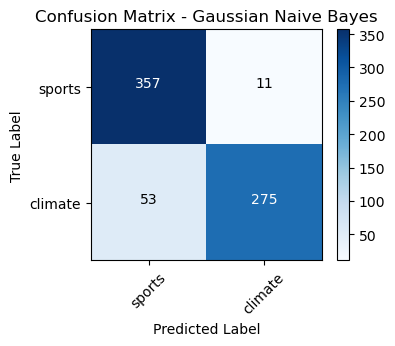

In [ ]:
gnb = GaussianNB()
gnb.fit(train_LSI, y_train)
gnb_predictions = gnb.predict(test_LSI)

cm_gnb = confusion_matrix(y_test, gnb_predictions)

evaluate_model(f"Gaussian Naive Bayes", y_test, gnb_predictions)

plot_roc_curve(gnb, test_LSI, y_test, "Gaussian Naive Bayes")
plot_confusion_matrix(cm_gnb, classes=class_names, title="Confusion Matrix - Gaussian Naive Bayes")

Grid Search of Parameters

In [60]:
stemmer = PorterStemmer()
def stem_text (text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

clean_transformer = FunctionTransformer(lambda x: x.apply(clean))
lemmatizer_transformer = FunctionTransformer(lambda x: x.apply(lemmatize_text))
stemmer_transformer = FunctionTransformer(lambda x: x.apply(stem_text))

pipeline = Pipeline([
    ('cleaner', clean_transformer),
    ('text_processing', FunctionTransformer(validate=False)),
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('dim_reduction', TruncatedSVD()),
    ('classifier', SVC())
])

param_grid = {
    'vectorizer__min_df': [2, 5],
    'text_processing': [lemmatizer_transformer, stemmer_transformer],
    'dim_reduction': [TruncatedSVD(random_state=42), NMF(random_state=42)],
    'dim_reduction__n_components': [5, 30, 100],
    'classifier': [
        SVC(kernel='linear', C=best_gamma, random_state=42),
        LogisticRegression(penalty='l1', C=best_C_l1, solver='liblinear', random_state=42),
        LogisticRegression(penalty='l2', C=best_C_l2, solver='liblinear', random_state=42),
        GaussianNB()
    ]
}

In [61]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train['full_text'], y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


/opt/anaconda3/envs/ece219/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/ece219/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/ece219/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/ece219/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/anaconda3/envs/ece219/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to imp

Best Parameters: {'classifier': LogisticRegression(C=100, random_state=42, solver='liblinear'), 'dim_reduction': TruncatedSVD(random_state=42), 'dim_reduction__n_components': 100, 'text_processing': FunctionTransformer(func=<function <lambda> at 0x31e2cb240>), 'vectorizer__min_df': 5}
Best Cross-Validation Accuracy: 0.9618705035971225



--- Model Configuration 58: {'classifier': LogisticRegression(C=100, random_state=42, solver='liblinear'), 'dim_reduction': TruncatedSVD(n_components=100, random_state=42), 'dim_reduction__n_components': 100, 'text_processing': 'Lemmatization', 'vectorizer__min_df': 5} ---
Top Model 58
Confusion Matrix:
[[350  18]
 [  7 321]]
Accuracy: 0.9641
Recall: 0.9787
Precision: 0.9469
F1 Score: 0.9625


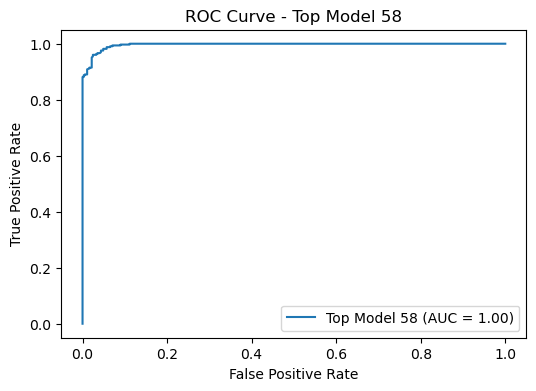

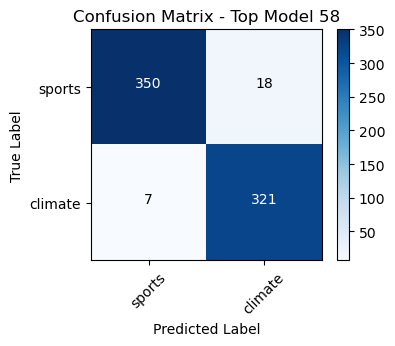


--- Model Configuration 34: {'classifier': LogisticRegression(C=10, penalty='l1', random_state=42, solver='liblinear'), 'dim_reduction': TruncatedSVD(n_components=100, random_state=42), 'dim_reduction__n_components': 100, 'text_processing': 'Lemmatization', 'vectorizer__min_df': 5} ---
Top Model 34
Confusion Matrix:
[[351  17]
 [  9 319]]
Accuracy: 0.9626
Recall: 0.9726
Precision: 0.9494
F1 Score: 0.9608


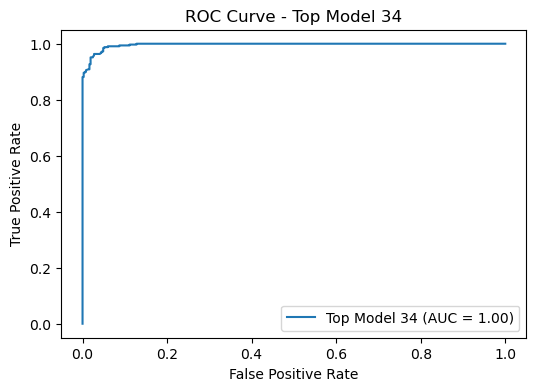

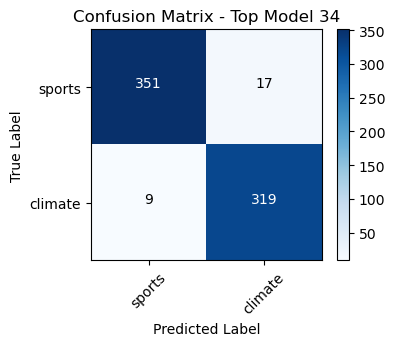


--- Model Configuration 57: {'classifier': LogisticRegression(C=100, random_state=42, solver='liblinear'), 'dim_reduction': TruncatedSVD(n_components=100, random_state=42), 'dim_reduction__n_components': 100, 'text_processing': 'Lemmatization', 'vectorizer__min_df': 2} ---
Top Model 57
Confusion Matrix:
[[351  17]
 [  7 321]]
Accuracy: 0.9655
Recall: 0.9787
Precision: 0.9497
F1 Score: 0.9640


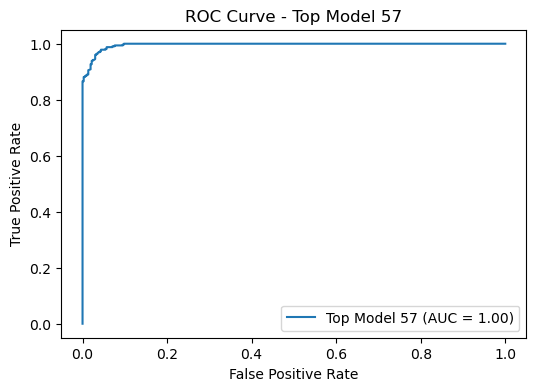

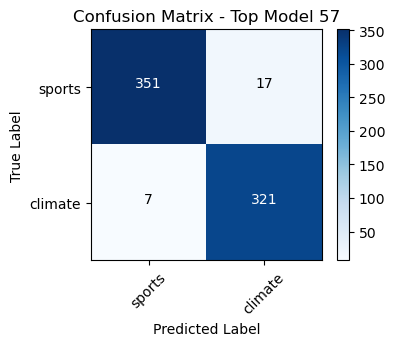


--- Model Configuration 9: {'classifier': SVC(C=10000, kernel='linear', random_state=42), 'dim_reduction': TruncatedSVD(n_components=100, random_state=42), 'dim_reduction__n_components': 100, 'text_processing': 'Lemmatization', 'vectorizer__min_df': 2} ---
Top Model 9
Confusion Matrix:
[[351  17]
 [  6 322]]
Accuracy: 0.9670
Recall: 0.9817
Precision: 0.9499
F1 Score: 0.9655


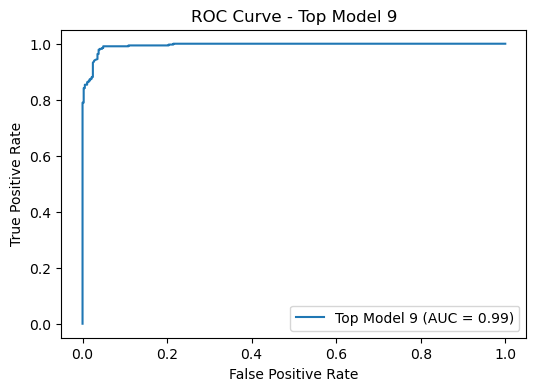

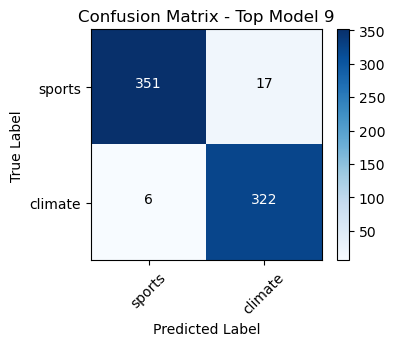


--- Model Configuration 10: {'classifier': SVC(C=10000, kernel='linear', random_state=42), 'dim_reduction': TruncatedSVD(n_components=100, random_state=42), 'dim_reduction__n_components': 100, 'text_processing': 'Lemmatization', 'vectorizer__min_df': 5} ---
Top Model 10
Confusion Matrix:
[[350  18]
 [  6 322]]
Accuracy: 0.9655
Recall: 0.9817
Precision: 0.9471
F1 Score: 0.9641


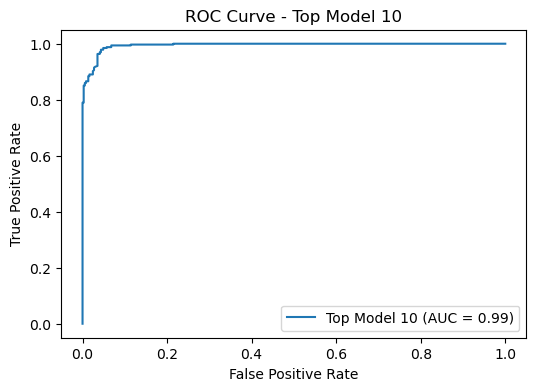

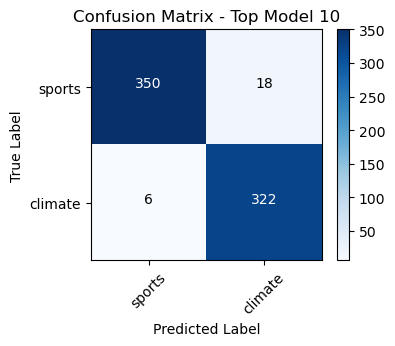

In [67]:
results_df = pd.DataFrame(grid_search.cv_results_)
top_5 = results_df.sort_values(by='mean_test_score', ascending=False).head(5)

text_processing_mapping = {
    str(lemmatizer_transformer): 'Lemmatization',
    str(stemmer_transformer): 'Stemming'
}

for i, row in top_5.iterrows():
    params = row['params']
    pipeline.set_params(**params)
    pipeline.fit(train['full_text'], y_train)

    text_processing_key = str(params['text_processing'])
    params['text_processing'] = text_processing_mapping.get(text_processing_key, 'Unknown')


    y_pred = pipeline.predict(test['full_text'])
    print(f"\n--- Model Configuration {i+1}: {params} ---")
    
    evaluate_model(f"Top Model {i+1}", y_test, y_pred)
    plot_roc_curve(pipeline, test['full_text'], y_test, f"Top Model {i+1}")
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=class_names, title=f"Confusion Matrix - Top Model {i+1}")


Multiclass Classification

In [67]:
np.random.seed(42)
random.seed(42)

In [68]:
train, test = train_test_split(df[["full_text", "leaf_label"]], test_size=0.2, random_state=42)
print("The training set has {} rows and {} columns.".format(train.shape[0], train.shape[1]))
print("The test set has {} rows and {} columns.".format(test.shape[0], test.shape[1]))

The training set has 2780 rows and 2 columns.
The test set has 696 rows and 2 columns.


Naive Bayes

In [69]:
map_row_to_class = {0: "basketball", 1: "baseball", 2: "tennis", 3: "football", 4: "soccer", 5: "forest fire", 6: "flood", 7: "earthquake", 8: "drought", 9: "heatwave"}
map_class_to_row = {k: v for v, k in map_row_to_class.items()}

train['num_label'] = train['leaf_label'].map(map_class_to_row)
test['num_label'] = test['leaf_label'].map(map_class_to_row)

y_train = train['num_label'].values
y_test = test['num_label'].values

class_names = [map_row_to_class[i] for i in range(len(map_row_to_class))]

In [70]:
nb_pipeline = Pipeline([
    ('cleaner', FunctionTransformer(lambda x: x.apply(clean))),
    ('text_processing', FunctionTransformer(lambda x: x.apply(lemmatize_text))),
    ('vectorizer', CountVectorizer(stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer()),
    ('dim_reduction', TruncatedSVD(n_components=100, random_state=42)),
    ('classifier', GaussianNB())
])

In [10]:
def evaluate_model_multi(title, y_true, y_hat):
    cm = confusion_matrix(y_true, y_hat)
    acc = accuracy_score(y_true, y_hat)
    rec = recall_score(y_true, y_hat, average='macro')
    prec = precision_score(y_true, y_hat, average='macro')
    f1 = f1_score(y_true, y_hat, average='macro')

    print(title)
    print(f"Confusion Matrix:\n{cm}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"F1 Score: {f1:.4f}")

Naive Bayes
Confusion Matrix:
[[80  6  1  2  1  0  0  0  0  0]
 [ 1 63  2  3  0  1  3  0  1  1]
 [ 0 22 40  0  4  2  1  0  0  0]
 [ 3  4  0 46  8  0  0  0  0  0]
 [ 3  7  0  1 62  0  0  0  0  0]
 [ 0  8  1  0  3  5  2  2 20 32]
 [ 0  2  0  0  0  0 62  0  2  0]
 [ 0  3  4  0  0  3  0 43  1  0]
 [ 0  3  2  0  0  0  0  0 63  0]
 [ 0  7  2  0  2 21  2  0 15 18]]
Accuracy: 0.6925
Recall: 0.6911
Precision: 0.6820
F1 Score: 0.6742


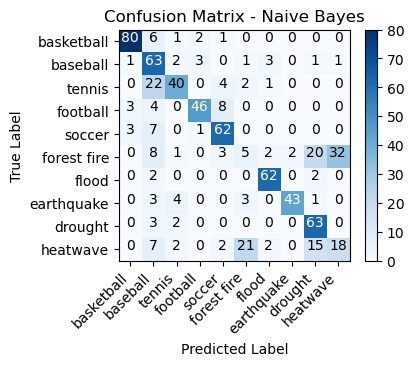

In [72]:
nb_pipeline.fit(train['full_text'], y_train)
y_pred = nb_pipeline.predict(test['full_text'])

cm_mnb = confusion_matrix(y_test, y_pred)

evaluate_model_multi(f"Naive Bayes", y_test, y_pred)
plot_confusion_matrix(cm_mnb, classes=class_names, title="Confusion Matrix - Naive Bayes")

SVM One VS One

One VS One SVM
Confusion Matrix:
[[84  3  1  0  0  1  0  0  0  1]
 [ 0 66  3  1  0  4  0  0  0  1]
 [ 0  7 57  0  1  1  1  0  0  2]
 [ 0  1  0 60  0  0  0  0  0  0]
 [ 0  5  0  1 67  0  0  0  0  0]
 [ 0  1  0  0  1 14  0  1  4 52]
 [ 0  2  0  0  0  4 60  0  0  0]
 [ 0  1  0  0  1  2  0 47  0  3]
 [ 0  1  0  0  0  0  0  0 59  8]
 [ 0  2  1  0  0 40  2  0  2 20]]
Accuracy: 0.7672
Recall: 0.7678
Precision: 0.7867
F1 Score: 0.7753


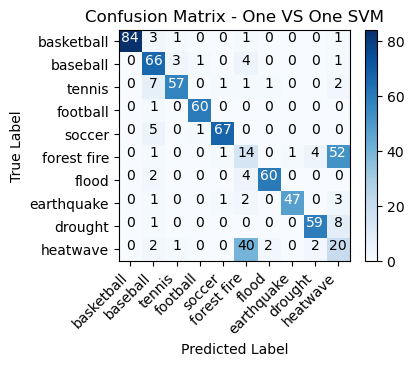

In [73]:
ovo_pipeline = Pipeline([
    ('cleaner', FunctionTransformer(lambda x: x.apply(clean))),
    ('text_processing', FunctionTransformer(lambda x: x.apply(lemmatize_text))),
    ('vectorizer', CountVectorizer(stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer()),
    ('dim_reduction', TruncatedSVD(n_components=100, random_state=42)),
    ('classifier', OneVsOneClassifier(LinearSVC(random_state=42)))
])

ovo_pipeline.fit(train['full_text'], y_train)
y_pred = ovo_pipeline.predict(test['full_text'])

cm_ovo = confusion_matrix(y_test, y_pred)

evaluate_model_multi(f"One VS One SVM", y_test, y_pred)
plot_confusion_matrix(cm_ovo, classes=class_names, title="Confusion Matrix - One VS One SVM")

SVM One VS Rest

One VS Rest SVM
Confusion Matrix:
[[84  1  0  3  0  2  0  0  0  0]
 [ 0 63  4  1  0  4  0  0  2  1]
 [ 0  7 58  0  1  1  1  0  0  1]
 [ 0  1  0 60  0  0  0  0  0  0]
 [ 0  2  0  1 69  0  0  0  0  1]
 [ 0  1  1  0  1 21  0  2  5 42]
 [ 0  2  0  0  0  3 61  0  0  0]
 [ 0  0  0  0  1  2  0 50  0  1]
 [ 0  2  0  0  0  1  0  0 60  5]
 [ 0  2  0  0  0 45  2  0  2 16]]
Accuracy: 0.7787
Recall: 0.7802
Precision: 0.7869
F1 Score: 0.7829


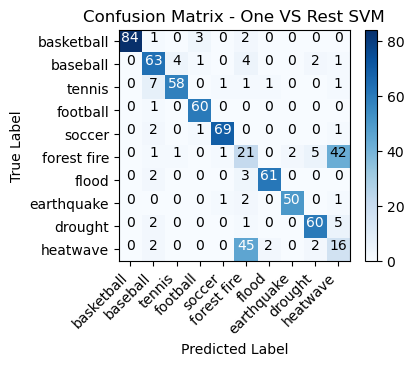

In [60]:
ovr_pipeline = Pipeline([
    ('cleaner', FunctionTransformer(lambda x: x.apply(clean))),
    ('text_processing', FunctionTransformer(lambda x: x.apply(lemmatize_text))),
    ('vectorizer', CountVectorizer(stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer()),
    ('dim_reduction', TruncatedSVD(n_components=100, random_state=42)),
    ('classifier', OneVsRestClassifier(LinearSVC(random_state=42, class_weight='balanced')))
])

ovr_pipeline.fit(train['full_text'], y_train)
y_pred = ovr_pipeline.predict(test['full_text'])

cm_ovr = confusion_matrix(y_test, y_pred)

evaluate_model_multi(f"One VS Rest SVM", y_test, y_pred)
plot_confusion_matrix(cm_ovr, classes=class_names, title="Confusion Matrix - One VS Rest SVM")

Merging heatwave with forest fire

In [74]:
map_row_to_class_merged = {0: "basketball", 1: "baseball", 2: "tennis", 3: "football", 4: "soccer", 5: "forest fire", 6: "flood", 7: "earthquake", 8: "drought"}
map_class_to_row_merged = {k: v for v, k in map_row_to_class_merged.items()}

train['merged_label'] = train['leaf_label'].replace({"heatwave": "forest fire"})
test['merged_label'] = test['leaf_label'].replace({"heatwave": "forest fire"})

train['num_label'] = train['merged_label'].map(map_class_to_row_merged)
test['num_label'] = test['merged_label'].map(map_class_to_row_merged)

y_train = train['num_label'].values
y_test = test['num_label'].values

class_names = [map_row_to_class[i] for i in range(len(map_row_to_class_merged))]

Naive Bayes

Naive Bayes Merged
Confusion Matrix:
[[80  6  1  2  1  0  0  0  0]
 [ 1 63  2  3  0  2  3  0  1]
 [ 0 22 40  0  4  2  1  0  0]
 [ 3  4  0 46  8  0  0  0  0]
 [ 3  7  0  1 62  0  0  0  0]
 [ 0 15  4  0  5 74  4  2 36]
 [ 0  2  0  0  0  0 62  0  2]
 [ 0  3  4  0  0  3  0 43  1]
 [ 0  3  2  0  0  0  0  0 63]]
Accuracy: 0.7658
Recall: 0.7892
Precision: 0.8005
F1 Score: 0.7779


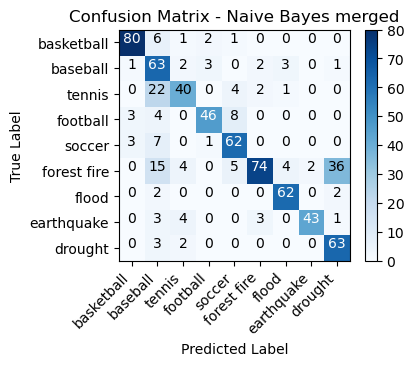

In [76]:
nb_pipeline.fit(train['full_text'], y_train)
y_pred = nb_pipeline.predict(test['full_text'])

cm_mnb = confusion_matrix(y_test, y_pred)

evaluate_model_multi(f"Naive Bayes Merged", y_test, y_pred)
plot_confusion_matrix(cm_mnb, classes=class_names, title="Confusion Matrix - Naive Bayes merged")

Without dealing with class imbalance

SVM One VS One

One VS One SVM Merged Imbalance
Confusion Matrix:
[[ 84   3   0   0   0   3   0   0   0]
 [  0  61   3   1   0  10   0   0   0]
 [  0   6  53   0   1   8   1   0   0]
 [  0   1   0  60   0   0   0   0   0]
 [  0   3   0   1  67   2   0   0   0]
 [  0   2   0   0   1 129   2   1   5]
 [  0   2   0   0   0   7  57   0   0]
 [  0   0   0   0   1   7   0  46   0]
 [  0   1   0   0   0   9   0   0  58]]
Accuracy: 0.8836
Recall: 0.8785
Precision: 0.9144
F1 Score: 0.8932


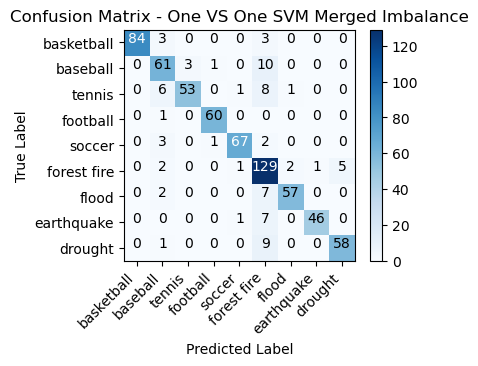

In [79]:
ovo_pipeline.fit(train['full_text'], y_train)
y_pred = ovo_pipeline.predict(test['full_text'])

cm_ovo = confusion_matrix(y_test, y_pred)

evaluate_model_multi(f"One VS One SVM Merged Imbalance", y_test, y_pred)
plot_confusion_matrix(cm_ovo, classes=class_names, title="Confusion Matrix - One VS One SVM Merged Imbalance")

SVM One VS Rest

One VS Rest SVM Merged Imbalance
Confusion Matrix:
[[ 88   0   0   0   0   2   0   0   0]
 [  0  60   3   2   0   8   0   0   2]
 [  0   6  55   1   0   6   1   0   0]
 [  0   0   0  61   0   0   0   0   0]
 [  0   1   1   1  68   2   0   0   0]
 [  0   2   0   0   1 128   2   1   6]
 [  0   1   0   0   0   4  61   0   0]
 [  0   1   0   0   0   4   0  49   0]
 [  0   1   0   0   0   9   0   0  58]]
Accuracy: 0.9023
Recall: 0.9006
Precision: 0.9207
F1 Score: 0.9091


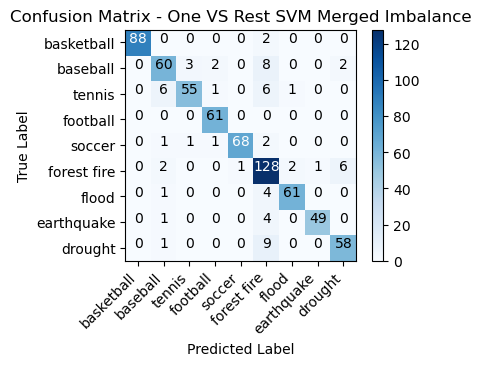

In [83]:
ovr_pipeline = Pipeline([
    ('cleaner', FunctionTransformer(lambda x: x.apply(clean))),
    ('text_processing', FunctionTransformer(lambda x: x.apply(lemmatize_text))),
    ('vectorizer', CountVectorizer(stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer()),
    ('dim_reduction', TruncatedSVD(n_components=100, random_state=42)),
    ('classifier', OneVsRestClassifier(LinearSVC(random_state=42, class_weight=None)))
])

ovr_pipeline.fit(train['full_text'], y_train)
y_pred = ovr_pipeline.predict(test['full_text'])

cm_ovr = confusion_matrix(y_test, y_pred)

evaluate_model_multi(f"One VS Rest SVM Merged Imbalance", y_test, y_pred)
plot_confusion_matrix(cm_ovr, classes=class_names, title="Confusion Matrix - One VS Rest SVM Merged Imbalance")

Dealing with class imbalance

SVM One VS One

One VS One SVM Merged Balanced
Confusion Matrix:
[[ 84   3   1   0   0   2   0   0   0]
 [  0  66   3   1   0   4   0   0   1]
 [  0   7  58   0   1   2   1   0   0]
 [  0   1   0  60   0   0   0   0   0]
 [  0   5   0   1  67   0   0   0   0]
 [  0   4   1   0   1 125   2   1   6]
 [  0   2   0   0   0   4  60   0   0]
 [  0   2   0   0   1   3   0  48   0]
 [  0   3   0   0   0   5   0   0  60]]
Accuracy: 0.9023
Recall: 0.9032
Precision: 0.9161
F1 Score: 0.9079


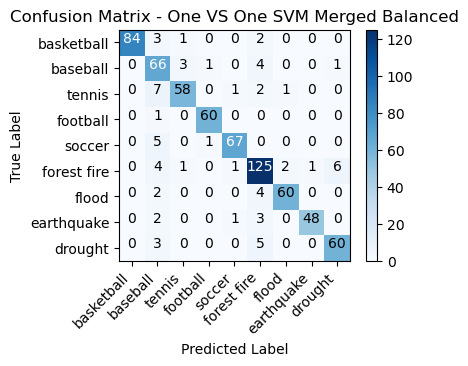

In [81]:
ovo_pipeline_balanced = Pipeline([
    ('cleaner', FunctionTransformer(lambda x: x.apply(clean))),
    ('text_processing', FunctionTransformer(lambda x: x.apply(lemmatize_text))),
    ('vectorizer', CountVectorizer(stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer()),
    ('dim_reduction', TruncatedSVD(n_components=100, random_state=42)),
    ('classifier', OneVsOneClassifier(LinearSVC(random_state=42, class_weight='balanced')))
])

ovo_pipeline_balanced.fit(train['full_text'], y_train)
y_pred = ovo_pipeline_balanced.predict(test['full_text'])

cm_ovo_balanced = confusion_matrix(y_test, y_pred)

evaluate_model_multi(f"One VS One SVM Merged Balanced", y_test, y_pred)
plot_confusion_matrix(cm_ovo_balanced, classes=class_names, title="Confusion Matrix - One VS One SVM Merged Balanced")

SVM One VS Rest

One VS Rest SVM Merged Balanced
Confusion Matrix:
[[ 84   1   0   3   1   1   0   0   0]
 [  0  63   4   1   0   5   0   0   2]
 [  0   7  58   0   1   2   1   0   0]
 [  0   1   0  60   0   0   0   0   0]
 [  0   2   0   1  69   1   0   0   0]
 [  0   3   0   0   1 125   2   1   8]
 [  0   2   0   0   0   4  60   0   0]
 [  0   0   0   0   1   3   0  50   0]
 [  0   2   0   0   0   7   0   0  59]]
Accuracy: 0.9023
Recall: 0.9042
Precision: 0.9127
F1 Score: 0.9076


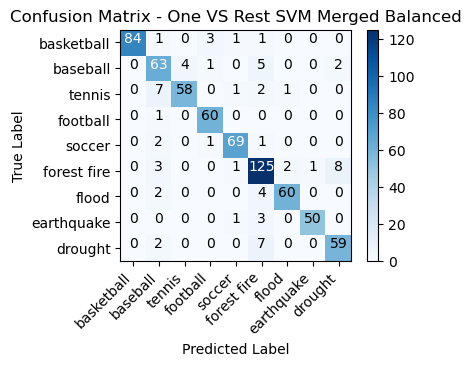

In [82]:
ovr_pipeline_balanced = Pipeline([
    ('cleaner', FunctionTransformer(lambda x: x.apply(clean))),
    ('text_processing', FunctionTransformer(lambda x: x.apply(lemmatize_text))),
    ('vectorizer', CountVectorizer(stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer()),
    ('dim_reduction', TruncatedSVD(n_components=100, random_state=42)),
    ('classifier', OneVsRestClassifier(LinearSVC(random_state=42, class_weight='balanced')))
])

ovr_pipeline_balanced.fit(train['full_text'], y_train)
y_pred = ovr_pipeline_balanced.predict(test['full_text'])

cm_ovr_balanced = confusion_matrix(y_test, y_pred)

evaluate_model_multi(f"One VS Rest SVM Merged Balanced", y_test, y_pred)
plot_confusion_matrix(cm_ovr_balanced, classes=class_names, title="Confusion Matrix - One VS Rest SVM Merged Balanced")

Word Embedding

In [11]:
embeddings_dict = {}
dimension_of_glove = 300
with open("glove.6B/glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = vector

In [13]:
train, test = train_test_split(df[["full_text", "root_label"]], test_size=0.2)
print("The training set has {} rows and {} columns.".format(train.shape[0], train.shape[1]))
print("The test set has {} rows and {} columns.".format(test.shape[0], test.shape[1]))

The training set has 2780 rows and 2 columns.
The test set has 696 rows and 2 columns.


In [15]:
train['full_text'] = train['full_text'].apply(clean).apply(lemmatize_text)
test['full_text'] = test['full_text'].apply(clean).apply(lemmatize_text)

def y_label(root_label):
    return 0 if 'sports' in root_label else 1

y_train = [y_label(label) for label in train['root_label']]
y_test = [y_label(label) for label in test['root_label']]

In [16]:
def compute_embeddings(sentence, embeddings_dict, dimension_of_glove):
    embeddings = []
    for text in sentence:
        words = text.split()
        word_vectors = [embeddings_dict[word] for word in words if word in embeddings_dict]
        if word_vectors:
            embeddings.append(np.mean(word_vectors, axis=0))
        else:
            embeddings.append(np.zeros(dimension_of_glove))
    return np.array(embeddings)

In [17]:
train_embeddings = compute_embeddings(train['full_text'], embeddings_dict, dimension_of_glove)
test_embeddings = compute_embeddings(test['full_text'], embeddings_dict, dimension_of_glove)

In [21]:
print(train_embeddings.shape)

(2780, 300)


In [22]:
log_reg = LogisticRegression(penalty='l1', C=10, solver="liblinear", random_state=42)
log_reg.fit(train_embeddings, y_train)

y_pred = log_reg.predict(test_embeddings)
evaluate_model_multi(f"Scores for Logistic Regression L1 after GloVe embeddings", y_test, y_pred)

Scores for Logistic Regression L1 after GloVe embeddings
Confusion Matrix:
[[348  20]
 [ 11 317]]
Accuracy: 0.9555
Recall: 0.9561
Precision: 0.9550
F1 Score: 0.9554


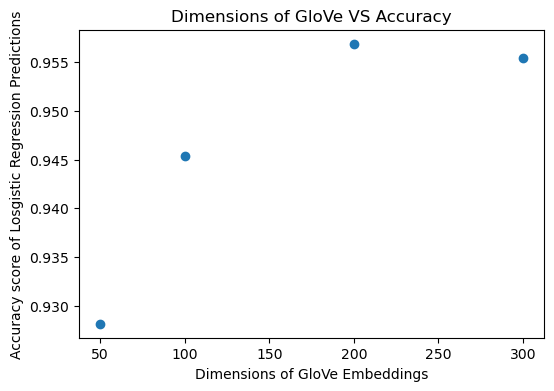

In [27]:
dimensions = [50, 100, 200, 300]
embedding_file = {
    50: "glove.6B.50d.txt",
    100: "glove.6B.100d.txt",
    200: "glove.6B.200d.txt",
    300: "glove.6B.300d.txt",
}
acc_score = []
for dim, file in embedding_file.items():
    embeddings_dict = {}
    with open(f"glove.6B/{file}", 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    train_embeddings = compute_embeddings(train['full_text'], embeddings_dict, dim)
    test_embeddings = compute_embeddings(test['full_text'], embeddings_dict, dim)
    log_reg = LogisticRegression(penalty='l1', C=10, solver="liblinear", random_state=42)
    log_reg.fit(train_embeddings, y_train)
    y_pred = log_reg.predict(test_embeddings)
    acc_score.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(6, 4))
plt.scatter(dimensions, acc_score, marker='o')
plt.xlabel("Dimensions of GloVe Embeddings")
plt.ylabel("Accuracy score of Losgistic Regression Predictions")
plt.title("Dimensions of GloVe VS Accuracy")
plt.show()

/opt/anaconda3/envs/ece219/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


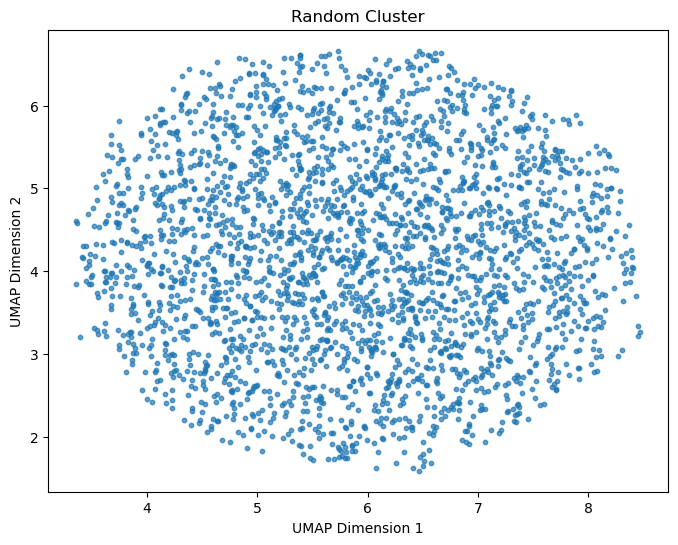

/opt/anaconda3/envs/ece219/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


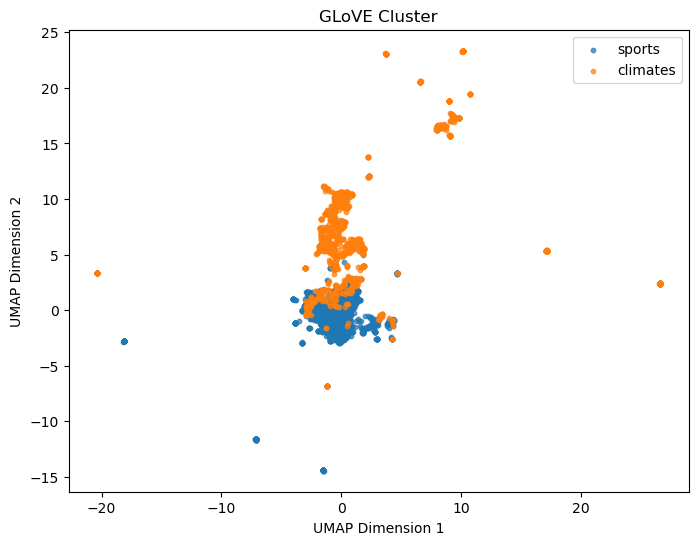

In [36]:

shape_of_train = np.array(train_embeddings).shape
sample = np.random.normal(0, 1, shape_of_train)
sample_normalized = sample / np.linalg.norm(sample, axis=1, keepdims=True)
reduce_sample = umap.UMAP(n_components=2, random_state=42).fit_transform(sample_normalized)

plt.figure(figsize=(8, 6))
plt.scatter(reduce_sample[:, 0], reduce_sample[:, 1], alpha=0.7, s=10)
plt.title('Random Cluster')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()

row_to_label = {0: "sports", 1: "climates"}
training_label = [row_to_label[i] for i in y_train]


train_embeddings_array = np.array(train_embeddings)
train_embeddings_normalized = train_embeddings_array / np.linalg.norm(train_embeddings_array, axis=1, keepdims=True)
reduced_dim_embedding = umap.UMAP(n_components=2, random_state=42).fit_transform(train_embeddings_normalized)

plt.figure(figsize=(8, 6))
for label in row_to_label.values():
    indices = [i for i, l in enumerate(training_label) if l == label]
    plt.scatter(reduced_dim_embedding[indices, 0], reduced_dim_embedding[indices, 1], label=label, alpha=0.7, s=10)

plt.title('GLoVE Cluster')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()
